In [1]:
# !pip install datasets

In [2]:
# Import the libraries

%matplotlib inline

from datasets import load_dataset
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# import nlp
import random


def show_history(h):
  # A function that visualizes train and test accuracy and loss
  # over epoch number
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.title('Model Accuracy')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
  # A function that plots the model confusion matrix
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.title('Confusion Matrix for Predicted Classes')
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.2


In [3]:
# load the Huggingface emotion dataset
data = load_dataset("emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# split the dataset into train, validation and test sets
train = data['train']
val = data['validation']
test = data['test']

In [5]:
# function that extracts text tweets and labels from the data
def get_tweet_label(data):
  tweets = [item['text'] for item in data]
  labels = [item['label'] for item in data]
  return tweets, labels

In [6]:
# get tweets and labels from the train dataset
tweets, labels = get_tweet_label(train)

In [7]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

Illustrate most commonly used words with a word cloud

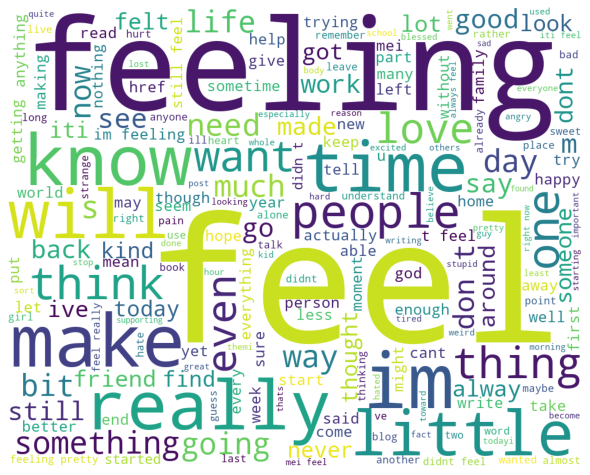

In [8]:
wordcloud = WordCloud(width = 1000, height = 800,
                background_color ='white',
                # stopwords = stopwords,
                min_font_size = 10).generate("".join(tweets))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## **Data Preparation for modeling**

In [9]:
# tokenize tweets
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>') # use 10,000 most frequently used words in the corpus
                                                          # tokenize everything else as unknown
tokenizer.fit_on_texts(tweets)

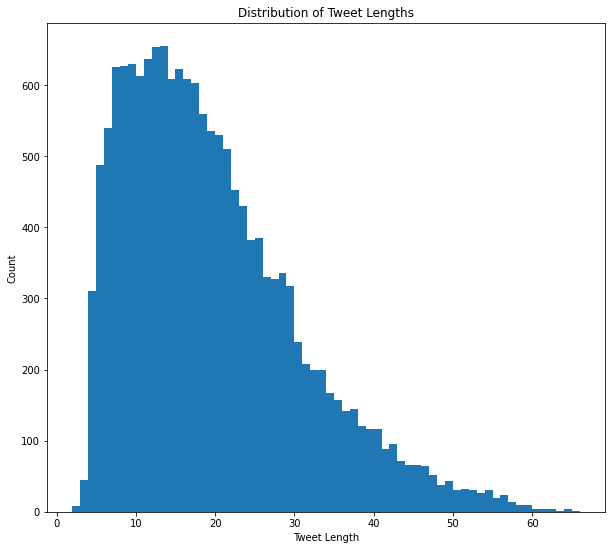

In [10]:
# pad and truncate sequences
lengths = [len(t.split(' ')) for t in tweets]
plt.rcParams['figure.figsize'] = (10,9)
plt.hist(lengths, bins=len(set(lengths)))
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.show()

In [11]:
# truncate any tweet that has more than 50 words and pad those that have less than 50 words
maxlen = 50

def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded_sequences = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded_sequences

In [12]:
# create padded sequences
train_padded_seq = get_sequences(tokenizer, tweets)
train_padded_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Understanding the labels

In [13]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


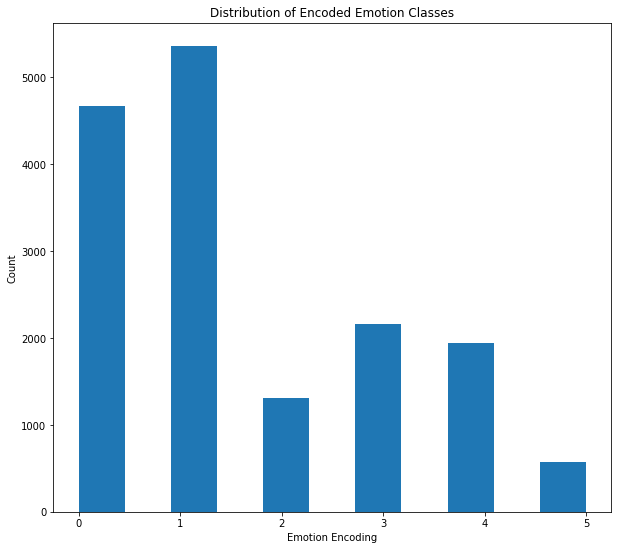

In [14]:
# plot label distribution
plt.rcParams['figure.figsize'] = (10,9)
plt.hist(labels, bins=11)
plt.title('Distribution of Encoded Emotion Classes')
plt.xlabel('Emotion Encoding')
plt.ylabel('Count')
plt.show()

In [15]:
label_meanings = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
class_to_index = dict((c, i) for i, c in enumerate(label_meanings))
index_to_class = dict((i, c) for c, i in class_to_index.items())

In [16]:
index_to_class

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

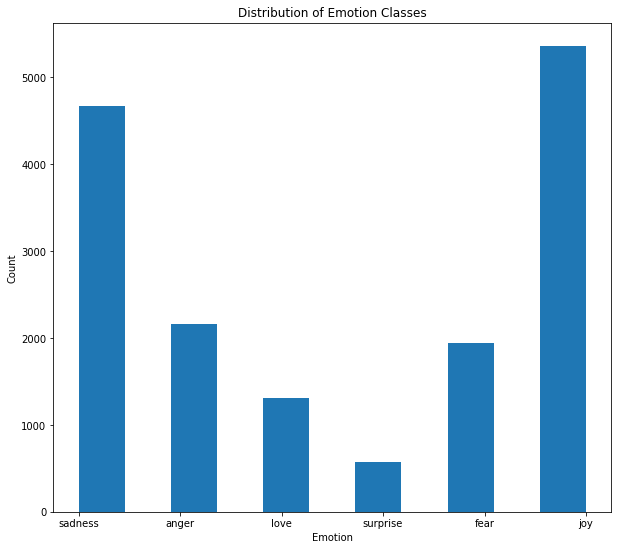

In [17]:
# plot label distribution showing emotion
plt.rcParams['figure.figsize'] = (10,9)
plt.hist([index_to_class[emotion] for emotion in labels], bins=11)
plt.title('Distribution of Emotion Classes')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

## Building the Model

In [18]:
# building the model and compile
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10001, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)), # bidirectional means that the context in LSTM can go
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),                       # both left to right and right to left
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160016    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 20)           2160      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               6560      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 168,982
Trainable params: 168,982
Non-trainable params: 0
_________________________________________________________________


In [19]:
# get the validation data
val_tweets, val_labels = get_tweet_label(val)
val_seq = get_sequences(tokenizer, val_tweets)

# turn everything to numpy array
training_padded = np.array(train_padded_seq)
training_labels = np.array(labels)
testing_padded = np.array(val_seq)
testing_labels = np.array(val_labels)

In [20]:
# fit the model 
h = model.fit(
    training_padded, training_labels,
    validation_data=(testing_padded, testing_labels),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
)

Epoch 1/20
500/500 [==============================] - 31s 51ms/step - loss: 1.3942 - accuracy: 0.3974 - val_loss: 1.0832 - val_accuracy: 0.5365
Epoch 2/20
500/500 [==============================] - 24s 48ms/step - loss: 0.8677 - accuracy: 0.6370 - val_loss: 0.7698 - val_accuracy: 0.7115
Epoch 3/20
500/500 [==============================] - 24s 47ms/step - loss: 0.5721 - accuracy: 0.7807 - val_loss: 0.6489 - val_accuracy: 0.7905
Epoch 4/20
500/500 [==============================] - 24s 48ms/step - loss: 0.3423 - accuracy: 0.8899 - val_loss: 0.4576 - val_accuracy: 0.8635
Epoch 5/20
500/500 [==============================] - 28s 56ms/step - loss: 0.2010 - accuracy: 0.9383 - val_loss: 0.4147 - val_accuracy: 0.8805
Epoch 6/20
500/500 [==============================] - 23s 45ms/step - loss: 0.1294 - accuracy: 0.9620 - val_loss: 0.4287 - val_accuracy: 0.8775
Epoch 7/20
500/500 [==============================] - 23s 47ms/step - loss: 0.1096 - accuracy: 0.9672 - val_loss: 0.3842 - val_accuracy:

## Model Evaluation

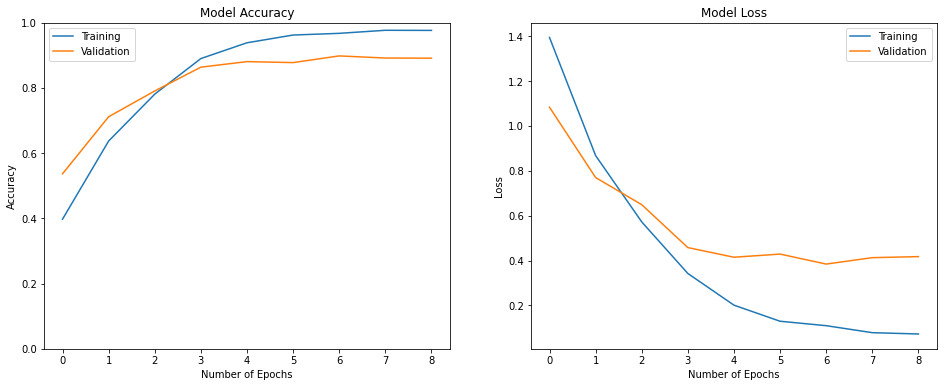

In [21]:
show_history(h)

In [22]:
test_tweets, test_labels = get_tweet_label(test)
test_sequences = np.array(get_sequences(tokenizer, test_tweets))
test_labels = np.array(test_labels)

In [23]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 1s 16ms/step - loss: 0.4939 - accuracy: 0.8635


In [24]:
rand_row = random.randint(0, len(test_labels)-1)

print('Sentence: ', test_tweets[rand_row])
print('Emotion: ', index_to_class[test_labels[rand_row]])

p = model.predict(np.expand_dims(test_sequences[rand_row], axis=0), verbose=0)[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion: ', pred_class)

Sentence:  i am feeling irritated anxious which is often then i dont even like my kids touching me
Emotion:  anger
Predicted Emotion:  anger


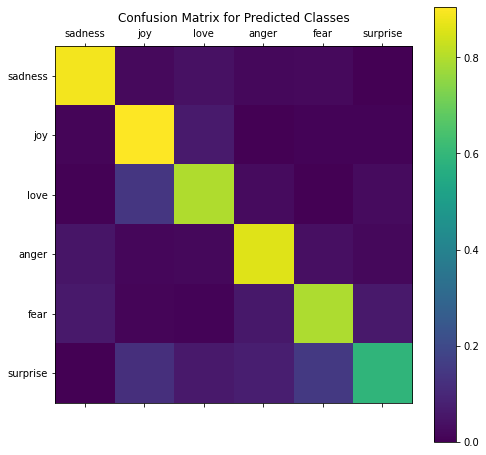

In [25]:
preds = np.argmax(model.predict(test_sequences, verbose=0), axis=1)
show_confusion_matrix(test_labels, preds, label_meanings)